# Bars:Beats Mapping

Maps detected beats to bar and beat numbers using an anchor at `HEAD_IN_START` (bar 1 beat 1). Infers beats-per-bar from beat-synchronous low-band (kick/bass) and mid/high-band (hihat/chuck) energy contrast.

**Inputs:**
- `data/derived/beats/{TRACK}_{MARKER_LABEL}_beats.npy` (beat times in seconds)
- `data/datasets/annotations/audio-markers/{TRACK}_markers.json` (must contain `HEAD_IN_START`)
- Audio from `RAW_AUDIO_DIR` for beat-level feature extraction

**Outputs:**
- `data/derived/bars/{TRACK}_{MARKER_LABEL}_bars.npy` (Nx3 matrix: time_sec, bar_number, beat_number)

In [1]:
import json
import sys
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from scipy.signal import butter, filtfilt

# Add project root for dijon imports (works from notebooks/scratch or project root)
project_root = Path.cwd()
if not (project_root / "src" / "dijon").exists():
    project_root = project_root.parent.parent
sys.path.insert(0, str(project_root))

from dijon.global_config import AUDIO_MARKERS_DIR, DERIVED_DIR, RAW_AUDIO_DIR
from dijon.notebook_ui import build_audio_with_cursor_html

%matplotlib inline

In [2]:
TRACK = "YTB-005"
MARKER = ""  # "" or None = full track; else e.g. "HEAD_IN", "LICK01"
MARKER_LABEL = "FULL" if not (MARKER and str(MARKER).strip()) else str(MARKER).upper().replace("-", "_")
WRITE_OUTPUT = False  # set True to save bars to data/derived/bars/

print(f"Track: {TRACK}  |  Marker: {MARKER or '(full track)'}")

Track: YTB-005  |  Marker: (full track)


In [3]:
# Load beat times
beats_path = DERIVED_DIR / "beats" / f"{TRACK}_{MARKER_LABEL}_beats.npy"
if not beats_path.exists():
    raise FileNotFoundError(f"Beat times not found: {beats_path}. Run beat_track.ipynb first.")
beat_times = np.load(beats_path).astype(np.float64)
if beat_times.ndim != 1:
    raise ValueError(f"Expected 1D beat array, got shape {beat_times.shape}")

# Load markers and require HEAD_IN_START
markers_path = AUDIO_MARKERS_DIR / f"{TRACK}_markers.json"
if not markers_path.exists():
    raise FileNotFoundError(f"Markers not found: {markers_path}")
with open(markers_path) as f:
    markers_data = json.load(f)
markers = markers_data["entries"][0]["markers"]
head_in_marker = next((m for m in markers if m["name"] == "HEAD_IN_START"), None)
if head_in_marker is None:
    raise ValueError(f"HEAD_IN_START marker required but not found in {markers_path}")
head_in_time_sec = float(head_in_marker["position"])

# Load audio for beat-level feature extraction
audio_path = RAW_AUDIO_DIR / f"{TRACK}.wav"
x_full, sr = librosa.load(audio_path, sr=None, mono=True)

print(f"Beats: {len(beat_times)} | HEAD_IN_START: {head_in_time_sec:.3f}s | Audio: {len(x_full)/sr:.2f}s @ {sr} Hz")

Beats: 702 | HEAD_IN_START: 1.122s | Audio: 175.48s @ 22050 Hz


In [4]:
def _band_rms(x, sr, low_hz=None, high_hz=None, order=4):
    """Extract RMS of a band-filtered signal. low_hz/high_hz define passband; None = no limit."""
    nyq = sr / 2
    if low_hz is not None and high_hz is not None:
        b, a = butter(order, [low_hz / nyq, high_hz / nyq], btype="band")
    elif low_hz is not None:
        b, a = butter(order, low_hz / nyq, btype="high")
    elif high_hz is not None:
        b, a = butter(order, high_hz / nyq, btype="low")
    else:
        return np.sqrt(np.mean(x ** 2))
    x_filt = filtfilt(b, a, x.astype(np.float64))
    return np.sqrt(np.mean(x_filt ** 2))


def compute_beat_energies(beat_times_sec, x, sr, win_half_sec=0.15, low_cut_hz=30, low_pass_hz=250, high_cut_hz=1600):
    """Compute low-band (kick/bass) and mid/high-band (hihat/chuck) RMS per beat."""
    n = len(beat_times_sec)
    low_energy = np.zeros(n)
    high_energy = np.zeros(n)
    half_samples = int(win_half_sec * sr)
    t = np.arange(len(x)) / sr

    for i in range(n):
        t_center = beat_times_sec[i]
        t_start = max(0, t_center - win_half_sec)
        t_end = min(len(x) / sr, t_center + win_half_sec)
        idx = (t >= t_start) & (t < t_end)
        if not np.any(idx):
            continue
        seg = x[idx]
        low_energy[i] = _band_rms(seg, sr, low_hz=low_cut_hz, high_hz=low_pass_hz)
        high_energy[i] = _band_rms(seg, sr, low_hz=high_cut_hz)

    return low_energy, high_energy


def estimate_beats_per_bar(beat_times_sec, head_in_time_sec, x, sr):
    """Infer beats-per-bar from low-band (strong beats) vs mid/high-band (weak beats) contrast."""
    b = np.asarray(beat_times_sec, dtype=np.float64)
    t0 = head_in_time_sec
    i0 = int(np.argmin(np.abs(b - t0)))

    low_energy, high_energy = compute_beat_energies(b, x, sr)

    # Normalize so scale differences don't dominate
    low_norm = low_energy / (np.std(low_energy) + 1e-10)
    high_norm = high_energy / (np.std(high_energy) + 1e-10)

    candidates = [2, 3, 4]
    best_score = -np.inf
    best_B = 2

    for B in candidates:
        downbeat_low = []
        other_low = []
        downbeat_high = []
        other_high = []
        for i in range(len(b)):
            k = i - i0
            pos = k % B
            if pos == 0:
                downbeat_low.append(low_norm[i])
                downbeat_high.append(high_norm[i])
            else:
                other_low.append(low_norm[i])
                other_high.append(high_norm[i])

        if not downbeat_low or not other_low:
            continue

        # Strong beats (1, 3): more low, less high
        score_low = np.mean(downbeat_low) - np.mean(other_low)
        # Weak beats (2, 4): more high, less low
        score_high = np.mean(other_high) - np.mean(downbeat_high)
        score = score_low + score_high

        if score > best_score:
            best_score = score
            best_B = B

    return best_B, low_energy, high_energy

In [5]:
beats_per_bar, low_energy, high_energy = estimate_beats_per_bar(
    beat_times, head_in_time_sec, x_full, sr
)
print(f"Inferred beats per bar: {beats_per_bar}")

Inferred beats per bar: 4


In [6]:
def label_bars_and_beats(beat_times_sec, head_in_time_sec, beats_per_bar):
    """Map each beat to (time_sec, bar_number, beat_number). Anchor at head_in = bar 1 beat 1."""
    b = np.asarray(beat_times_sec, dtype=np.float64)
    B = int(beats_per_bar)
    i0 = int(np.argmin(np.abs(b - head_in_time_sec)))

    labels = []
    for i in range(len(b)):
        k = i - i0
        bar_number = 1 + (k // B)
        beat_number = 1 + (k % B)
        labels.append((float(b[i]), bar_number, beat_number))

    return np.array(labels)

In [7]:
labels = label_bars_and_beats(beat_times, head_in_time_sec, beats_per_bar)

In [8]:
bars_dir = DERIVED_DIR / "bars"
bars_dir.mkdir(parents=True, exist_ok=True)
out_path = bars_dir / f"{TRACK}_{MARKER_LABEL}_bars.npy"
if WRITE_OUTPUT:
    np.save(out_path, labels)
print(f"Track: {TRACK} | Marker: {MARKER_LABEL} | B: {beats_per_bar} | Anchor: {head_in_time_sec:.3f}s")
if WRITE_OUTPUT:
    print(f"Saved to: {out_path}")

Track: YTB-005 | Marker: FULL | B: 4 | Anchor: 1.122s


In [9]:
print(f"Beats: {len(labels)} | Beats per bar: {beats_per_bar}")
print("\nFirst 10 rows (time_sec, bar, beat):")
print(labels[:10])
print("\nLast 10 rows:")
print(labels[-10:])

Beats: 702 | Beats per bar: 4

First 10 rows (time_sec, bar, beat):
[[0.31 0.   2.  ]
 [0.59 0.   3.  ]
 [0.86 0.   4.  ]
 [1.12 1.   1.  ]
 [1.35 1.   2.  ]
 [1.62 1.   3.  ]
 [1.87 1.   4.  ]
 [2.13 2.   1.  ]
 [2.38 2.   2.  ]
 [2.64 2.   3.  ]]

Last 10 rows:
[[170.66 173.     2.  ]
 [170.92 173.     3.  ]
 [171.15 173.     4.  ]
 [171.37 174.     1.  ]
 [171.59 174.     2.  ]
 [171.81 174.     3.  ]
 [172.07 174.     4.  ]
 [172.32 175.     1.  ]
 [172.57 175.     2.  ]
 [172.82 175.     3.  ]]


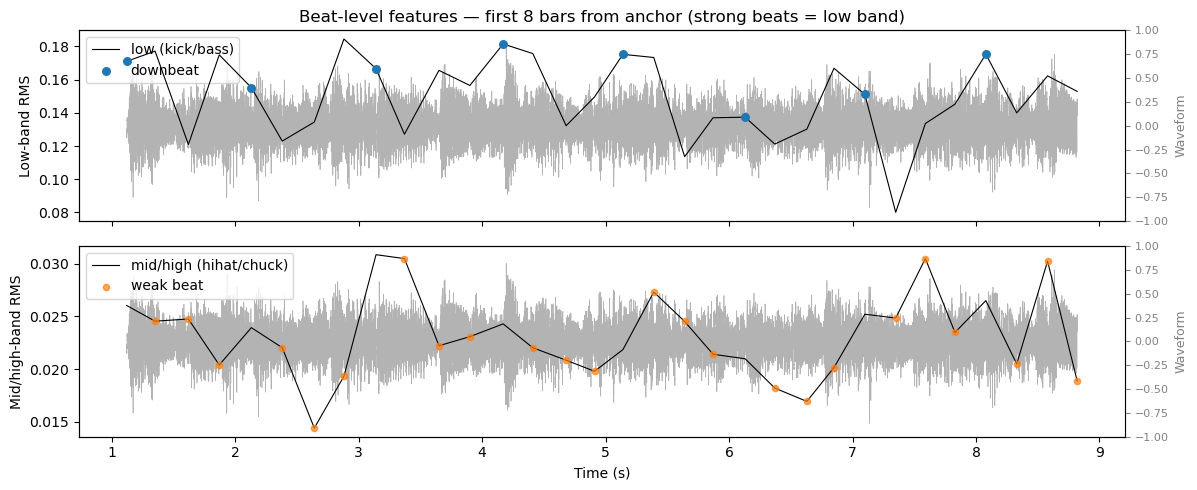


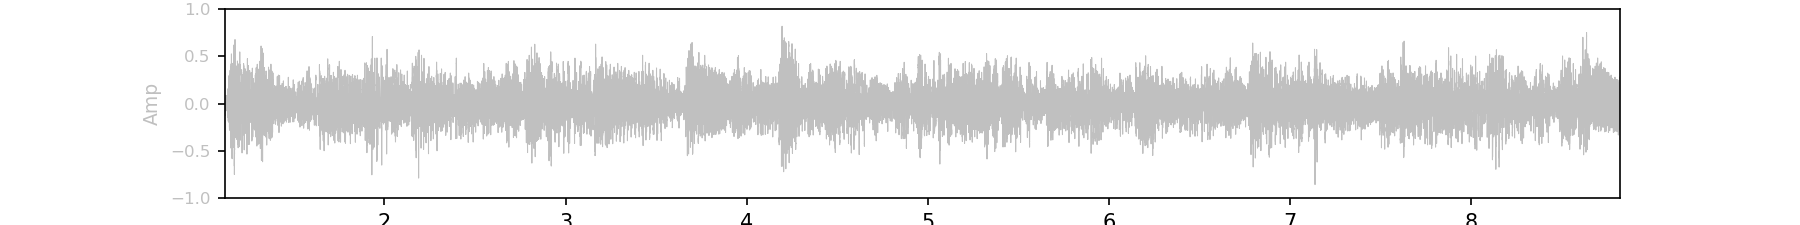

In [10]:
i0 = int(np.argmin(np.abs(beat_times - head_in_time_sec)))
is_downbeat = ((np.arange(len(beat_times)) - i0) % beats_per_bar) == 0

# Zoom to first 8 bars from anchor for horizontal detail
bar_idx = (np.arange(len(beat_times)) - i0) // beats_per_bar
mask = (bar_idx >= 0) & (bar_idx < 8)
t_plot = beat_times[mask]
low_plot = low_energy[mask]
high_plot = high_energy[mask]
db_plot = is_downbeat[mask]

# Waveform segment for plot range (light grey, full height -1 to 1)
t_min, t_max = t_plot[0], t_plot[-1]
start_samp = int(t_min * sr)
end_samp = min(int(t_max * sr) + 1, len(x_full))
x_seg = x_full[start_samp:end_samp]
t_wf = np.arange(len(x_seg)) / sr + t_min

fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 5))

# Low-band plot — waveform behind (grey), feature line on top
ax0_twin = axes[0].twinx()
ax0_twin.plot(t_wf, x_seg, color="0.7", linewidth=0.5, zorder=0)
ax0_twin.set_ylim(-1, 1)
ax0_twin.set_ylabel("Waveform", color="0.5", fontsize=9)
ax0_twin.tick_params(axis="y", colors="0.5", labelsize=8)
ax0_twin.spines["right"].set_color("0.7")
ax0_twin.set_zorder(0)
axes[0].patch.set_visible(False)
axes[0].set_zorder(1)
axes[0].plot(t_plot, low_plot, "k-", linewidth=0.8, label="low (kick/bass)", zorder=10)
axes[0].scatter(t_plot[db_plot], low_plot[db_plot], c="C0", s=30, zorder=10, label="downbeat")
axes[0].set_ylabel("Low-band RMS")
axes[0].legend(loc="upper left")
axes[0].set_title("Beat-level features — first 8 bars from anchor (strong beats = low band)")

# Mid/high-band plot — waveform behind (grey), feature line on top
ax1_twin = axes[1].twinx()
ax1_twin.plot(t_wf, x_seg, color="0.7", linewidth=0.5, zorder=0)
ax1_twin.set_ylim(-1, 1)
ax1_twin.set_ylabel("Waveform", color="0.5", fontsize=9)
ax1_twin.tick_params(axis="y", colors="0.5", labelsize=8)
ax1_twin.spines["right"].set_color("0.7")
ax1_twin.set_zorder(0)
axes[1].patch.set_visible(False)
axes[1].set_zorder(1)
axes[1].plot(t_plot, high_plot, "k-", linewidth=0.8, label="mid/high (hihat/chuck)", zorder=10)
axes[1].scatter(t_plot[~db_plot], high_plot[~db_plot], c="C1", s=20, alpha=0.7, zorder=10, label="weak beat")
axes[1].set_ylabel("Mid/high-band RMS")
axes[1].set_xlabel("Time (s)")
axes[1].legend(loc="upper left")
plt.tight_layout()
plt.show()

# Sonification: low-freq clicks on downbeats, high-freq clicks on weak beats
clicks_low = librosa.clicks(times=t_plot[db_plot] - t_min, sr=sr, click_freq=400, length=len(x_seg), click_duration=0.06)
clicks_high = librosa.clicks(times=t_plot[~db_plot] - t_min, sr=sr, click_freq=2000, length=len(x_seg), click_duration=0.05)
x_sonified = x_seg + 0.6 * clicks_low + 0.4 * clicks_high

# Waveform-only view with audio player and dynamic cursor (sonified)
duration_seg = len(x_seg) / sr
fig_audio, ax_audio = plt.subplots(figsize=(12, 1.5))
ax_audio.plot(t_wf, x_seg, color="#c0c0c0", linewidth=0.5)
ax_audio.set_ylabel("Amp", color="#c0c0c0", fontsize=9)
ax_audio.set_xlabel("Time (s)", fontsize=9)
ax_audio.set_xlim(t_min, t_max)
ax_audio.set_ylim(-1, 1)
ax_audio.tick_params(axis="y", labelcolor="#c0c0c0", labelsize=8)
fig_audio.subplots_adjust(top=0.96, bottom=0.12)
h_audio = build_audio_with_cursor_html(x_sonified, sr, fig=fig_audio, ax=ax_audio, max_duration_sec=max(60, duration_seg), close_fig=True)
display(HTML("<div style='margin-top:1rem;'>" + h_audio.html + "</div>"))